# Collaboration and Competition

---

This notebook runs John's solution for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.  It uses the Unity ML-Agents environment to train two cooperative agents to play a tennis-like game.

**Need more description here - refer to readme?**






...


This code depends upon a custom Unity environment provided by the Udacity staff that embodies the variation on tennis.  It will open a separate Unity window for visualizing the environment as the agents train or play.


## Define how we will use this notebook - JOHN FIX THIS!!!!

In the next cell, set the appropriate values of a couple control variables:
- **EXPLORE** determines whether the notebook does exploratory training or inference demonstration.
    - **True** runs a hyperparameter exploration loop to generate many training runs with a random search algorithm.  To use this well, you should study that cell and specify the ranges of hyperparameters to be explored.
    - **False** runs a few inference episodes of a pretrained model and opens a visualization window to watch it play.
- **config_name:** the name of a model configuration & run to be loaded from a checkpoint to begin the exercise.  
    - If EXPLORE = True, this is optional, and tells the training loop to start from this pre-trained model and continue refining it; if the value is _None_ then the training starts from a randomly initialized model.
    - If EXPLORE = False, then this must reflect the name of a legitimate config/run (e.g. "M37.01").
- **checkpoint_episode:** if a checkpoint is being used to start the exercise, then this number reflects what episode that checkpoint was captured from.  The checkpoint_name and checkpoint_episode together are required to completely identify the checkpoint file.


In [1]:
EXPLORE            = True
config_name        = None # Must be None if not using!
run_number         = 0
checkpoint_episode = 2

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from train import train
from maddpg import Maddpg

%matplotlib inline

initial_episode = checkpoint_episode
checkpoint_path = "checkpoint/{}/".format(config_name)
tag = "{}.{:02d}".format(config_name, run_number)

if EXPLORE:
    turn_off_graphics = True
    initial_episode = 0
    unity_train_mode = True
    if config_name != None:
        initial_episode = checkpoint_episode
else:
    turn_off_graphics = False
    unity_train_mode = False

# create a new Unity environment
# it needs to be done once, outside any loop, as closing an environment then restarting causes
# a Unity exception about the handle no longer being active.
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", seed=0, 
                       no_graphics=turn_off_graphics)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]                       
env_info = env.reset(train_mode=unity_train_mode)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Train the agents

The next cells will invoke the training program to create the agents.  All of the real code is in Python flat files in this project directory.

In [3]:
import numpy as np

class RandomSampler():
    
    def __init__(self, vars):
        """Accepts definition of the set of variables to be sampled.
            
            Params:
                vars (list of lists): each item is a list containing:
                                        item 0 - either 'discrete', 'continuous-int' or 'continuous-float'
                                        items 1-N depend on the value of item 0:
                                        if discrete, then these are the set of values to be chosen from
                                        if continuous then these are the min & max bounds of the range
        """
        
        self.vars = vars
        
        self.rng = np.random.default_rng()
    
    
    def sample(self):
        """Draws a random sample of all variables at its disposal.
        
            Returns a list of values in the order of definition.
        """

        rtn = []
        for v in self.vars:
            if v[0] == "discrete":
                choice = self.rng.integers(low=1, high=len(v), size=1)[0]
                rtn.append(v[choice])
                
            elif v[0] == "continuous-int":
                choice = self.rng.integers(low=v[1], high=v[2], size=1)[0]
                rtn.append(choice)
                
            elif v[0] == "continuous-float":
                choice = self.rng.random() * (v[2]-v[1]) + v[1]
                rtn.append(choice)
            
            else:
                print("///// RandomSampler error:  unknown type ", v[0])
            
        return rtn
                
vars = [["discrete", 88, 66, 11, 22, 33, 44, 99, 101, 77],
        ["discrete", 500], #1-item list
        ["continuous-int", 43, 44], #1-item range
        ["continuous-int", 0, 10],
        ["continuous-float", 0.0, 1.0],
        ["continuous-float", -3.3, 0.0],
        ["continuous-float", -1.0, 6.4],
       ]
rs = RandomSampler(vars)

for i in range(3):
    out = rs.sample()
    print("\n", i, "\n", out)



 0 
 [66, 500, 43, 6, 0.7647809559540368, -1.1282539059997072, 2.366867230055097]

 1 
 [77, 500, 43, 5, 0.5515562255142659, -1.415187169003523, 5.785217047858464]

 2 
 [22, 500, 43, 3, 0.6596442412229682, -0.6743572039034147, 1.5403879357940355]


Ready to train M45 over 30 training sets for 10001 episodes each, with fixed params:
    Max episodes   =  10001
    Weight decay   =  1e-05
    Gamma          =  0.99
    LR anneal freq =  10000
    LR anneal mult =  1.0
    Buf prime size =  5000

///// Beginning training set  M45.00  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999103
      Noise scale      = 0.020
      LR actor         = 0.0003008
      LR critic        = 0.0002885
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00363
      Seed             =  44939
Priming the replay buffer........................!

73	Running avg/max: 0.003/0.100,  mem:   6273/     2 ( 0.0%), avg 504.8 eps/min   
* noise mult = 0.1
251	Running avg/max: 0.007/0.200,  mem:   9232/     9 ( 0.1%), avg 514.7 eps/min   
* noise mult = 0.0005
1000	Average score:   0.009,        mem:  21685/    38 ( 0.2%), avg 521.1 eps/min;  

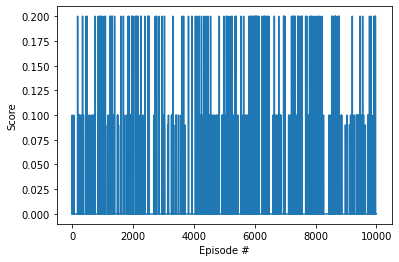

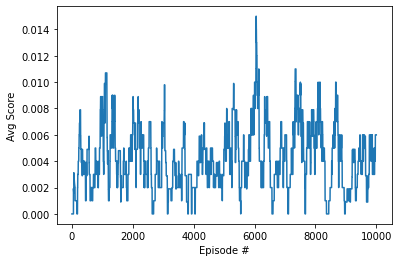


///// Beginning training set  M45.01  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999273
      Noise scale      = 0.100
      LR actor         = 0.0001453
      LR critic        = 0.0000237
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00762
      Seed             =  44939
Priming the replay buffer.........................!

101	Running avg/max: 0.001/0.090,  mem:   5236/     1 ( 0.0%), avg 506.9 eps/min   
* noise mult = 0.1
338	Running avg/max: 0.006/0.100,  mem:   5807/    10 ( 0.2%), avg 500.7 eps/min   
* noise mult = 0.0005
1000	Average score:   0.005,        mem:   7368/    31 ( 0.4%), avg 492.8 eps/min;  0.3 hr rem   
2000	Average score:   0.004,        mem:   9670/    69 ( 0.7%), avg 492.2 eps/min;  0.3 hr rem   
3000	Average score:   0.005,        mem:  12096/   113 ( 0.9%), avg 488.5 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        m

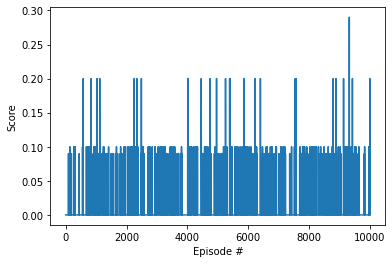

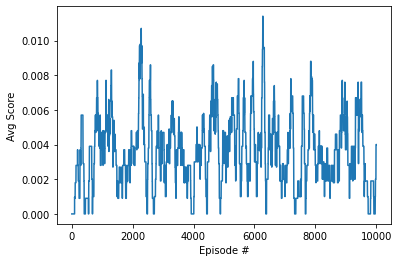


///// Beginning training set  M45.02  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999849
      Noise scale      = 0.020
      LR actor         = 0.0005512
      LR critic        = 0.0005007
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00689
      Seed             =  44939
Priming the replay buffer.........................!

448	Running avg/max: 0.002/0.100,  mem:  12651/    15 ( 0.1%), avg 107.4 eps/min   
* noise mult = 0.1
1000	Average score:   0.004,        mem:  22103/    33 ( 0.1%), avg 109.9 eps/min;  1.4 hr rem   
1480	Running avg/max: 0.001/0.100,  mem:  30244/    45 ( 0.1%), avg 104.1 eps/min   
* noise mult = 0.0005
2000	Average score:   0.004,        mem:  39014/    58 ( 0.1%), avg 53.8 eps/min;  2.5 hr rem   
3000	Average score:   0.002,        mem:  56132/    94 ( 0.2%), avg 29.1 eps/min;  4.0 hr rem   
4000	Average score:   0.004,        mem

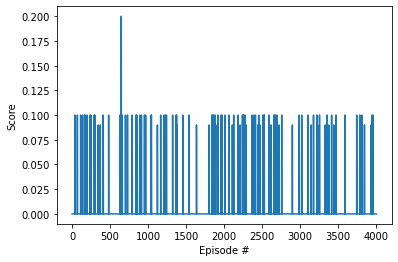

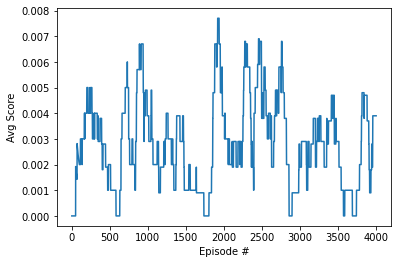


///// Beginning training set  M45.03  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999171
      Noise scale      = 1.000
      LR actor         = 0.0002170
      LR critic        = 0.0001186
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00639
      Seed             =  44939
Priming the replay buffer........................!

80	Running avg/max: 0.007/0.200,  mem:   5204/     6 ( 0.1%), avg 101.3 eps/min   
* noise mult = 0.1
288	Running avg/max: 0.000/0.000,  mem:   5691/    10 ( 0.2%), avg 105.0 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7284/    10 ( 0.1%), avg 111.1 eps/min;  1.3 hr rem   
2000	Average score:   0.000,        mem:   9527/    10 ( 0.1%), avg 114.4 eps/min;  1.2 hr rem   
3000	Average score:   0.000,        mem:  11689/    10 ( 0.1%), avg 116.0 eps/min;  1.0 hr rem   
4000	Average score:   0.000,        mem:

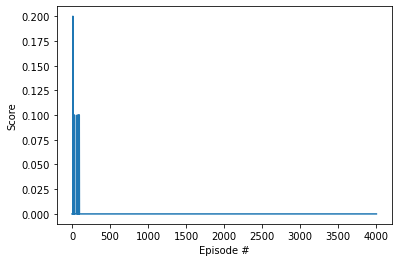

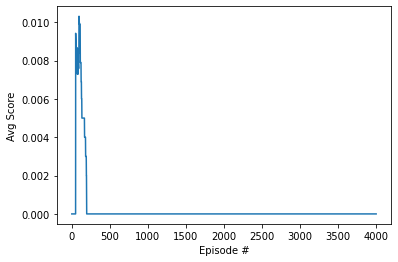


///// Beginning training set  M45.04  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999230
      Noise scale      = 1.000
      LR actor         = 0.0005028
      LR critic        = 0.0001534
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00326
      Seed             =  44939
Priming the replay buffer.........................!

93	Running avg/max: 0.001/0.100,  mem:   5210/     1 ( 0.0%), avg 469.8 eps/min   
* noise mult = 0.1
301	Running avg/max: 0.000/0.000,  mem:   5728/     1 ( 0.0%), avg 460.3 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7429/     1 ( 0.0%), avg 470.6 eps/min;  0.3 hr rem   
2000	Average score:   0.000,        mem:   9842/     1 ( 0.0%), avg 473.2 eps/min;  0.3 hr rem   
3000	Average score:   0.000,        mem:  12258/     1 ( 0.0%), avg 473.4 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        me

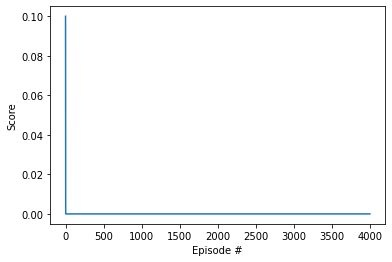

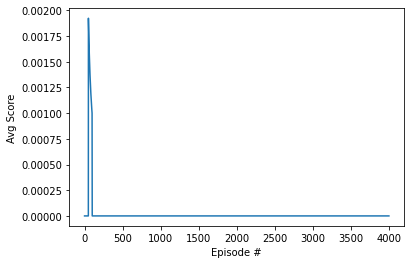


///// Beginning training set  M45.05  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999218
      Noise scale      = 0.020
      LR actor         = 0.0009220
      LR critic        = 0.0004980
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00758
      Seed             =  44939
Priming the replay buffer........................!

97	Running avg/max: 0.000/0.000,  mem:   6461/     0 ( 0.0%), avg 517.6 eps/min   
* noise mult = 0.1
319	Running avg/max: 0.000/0.000,  mem:   9855/     0 ( 0.0%), avg 508.6 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  20089/     0 ( 0.0%), avg 508.0 eps/min;  0.3 hr rem   
2000	Average score:   0.000,        mem:  35167/     0 ( 0.0%), avg 506.3 eps/min;  0.3 hr rem   
3000	Average score:   0.000,        mem:  50253/     0 ( 0.0%), avg 504.0 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        mem

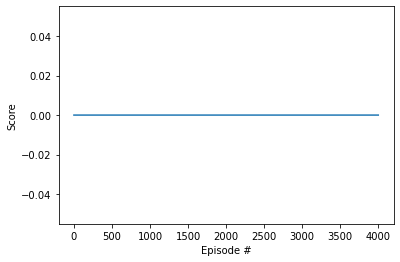

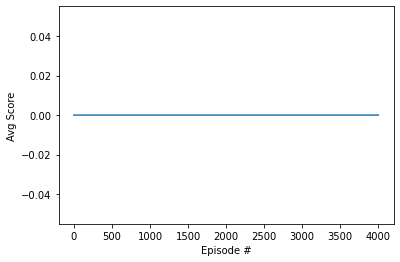


///// Beginning training set  M45.06  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999491
      Noise scale      = 0.100
      LR actor         = 0.0007829
      LR critic        = 0.0002914
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00703
      Seed             =  44939
Priming the replay buffer.........................!

124	Running avg/max: 0.005/0.200,  mem:   7251/     5 ( 0.1%), avg 91.8 eps/min   
* noise mult = 0.1
420	Running avg/max: 0.007/0.200,  mem:  12450/    25 ( 0.2%), avg 94.5 eps/min   
* noise mult = 0.0005
1000	Average score:   0.001,        mem:  22398/    48 ( 0.2%), avg 97.9 eps/min;  1.5 hr rem   
2000	Average score:   0.002,        mem:  39721/   102 ( 0.3%), avg 53.5 eps/min;  2.5 hr rem   
3000	Average score:   0.009,        mem:  56961/   143 ( 0.3%), avg 29.0 eps/min;  4.0 hr rem   
4000	Average score:   0.008,        mem:  7

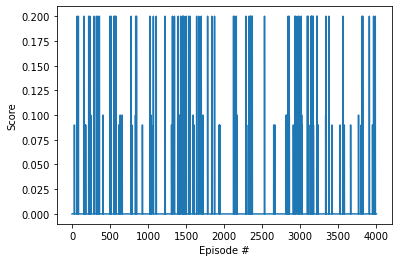

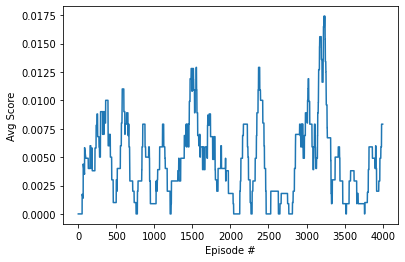


///// Beginning training set  M45.07  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999670
      Noise scale      = 0.100
      LR actor         = 0.0007810
      LR critic        = 0.0003786
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00428
      Seed             =  44939
Priming the replay buffer.........................!

228	Running avg/max: 0.000/0.000,  mem:   8489/     0 ( 0.0%), avg 116.5 eps/min   
* noise mult = 0.1
762	Running avg/max: 0.000/0.000,  mem:  16532/     0 ( 0.0%), avg 118.2 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  20146/     0 ( 0.0%), avg 117.4 eps/min;  1.3 hr rem   
2000	Average score:   0.000,        mem:  35345/     0 ( 0.0%), avg 64.1 eps/min;  2.1 hr rem   
3000	Average score:   0.000,        mem:  50602/     0 ( 0.0%), avg 38.3 eps/min;  3.0 hr rem   
4000	Average score:   0.000,        mem:

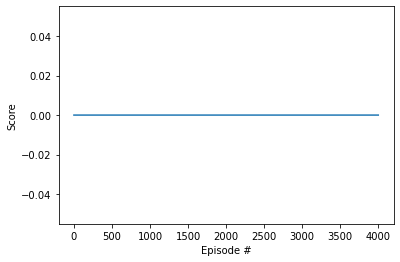

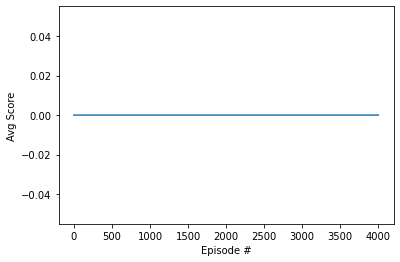


///// Beginning training set  M45.08  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999275
      Noise scale      = 0.020
      LR actor         = 0.0004755
      LR critic        = 0.0001206
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00658
      Seed             =  44939
Priming the replay buffer.........................!

108	Running avg/max: 0.001/0.100,  mem:   5220/     1 ( 0.0%), avg 289.2 eps/min   
* noise mult = 0.1
347	Running avg/max: 0.003/0.100,  mem:   5782/     7 ( 0.1%), avg 281.5 eps/min   
* noise mult = 0.0005
1000	Average score:   0.001,        mem:   7288/    34 ( 0.5%), avg 276.5 eps/min;  0.5 hr rem   
2000	Average score:   0.002,        mem:   9615/    64 ( 0.7%), avg 277.7 eps/min;  0.5 hr rem   
3000	Average score:   0.004,        mem:  11931/    98 ( 0.8%), avg 280.3 eps/min;  0.4 hr rem   
4000	Average score:   0.004,        me

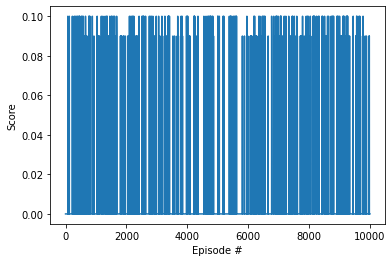

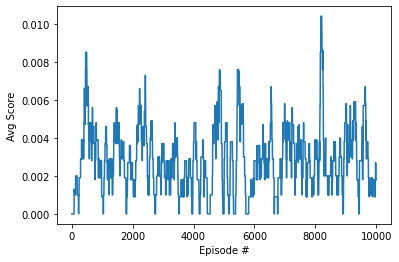


///// Beginning training set  M45.09  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999530
      Noise scale      = 1.000
      LR actor         = 0.0001964
      LR critic        = 0.0001873
      Learning every      80  time steps
      Learn iterations =  1
      Tau              = 0.00352
      Seed             =  44939
Priming the replay buffer.........................!

152	Running avg/max: 0.003/0.100,  mem:   5371/    10 ( 0.2%), avg 1080.6 eps/min   
* noise mult = 0.1
524	Running avg/max: 0.004/0.100,  mem:   6243/    20 ( 0.3%), avg 1105.1 eps/min   
* noise mult = 0.0005
1000	Average score:   0.008,        mem:   7332/    39 ( 0.5%), avg 1091.5 eps/min;  0.1 hr rem   
2000	Average score:   0.007,        mem:   9649/    75 ( 0.8%), avg 1092.3 eps/min;  0.1 hr rem   
3000	Average score:   0.003,        mem:  11969/   115 ( 1.0%), avg 1098.4 eps/min;  0.1 hr rem   
4000	Average score:   0.005,    

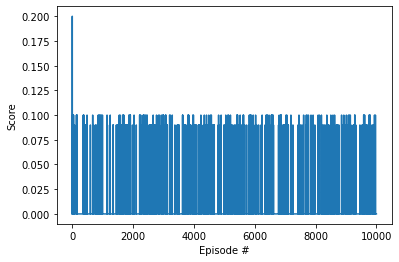

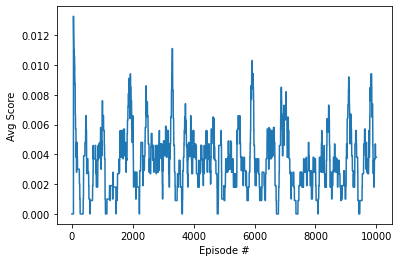


///// Beginning training set  M45.10  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999102
      Noise scale      = 0.100
      LR actor         = 0.0009224
      LR critic        = 0.0004489
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00460
      Seed             =  44939
Priming the replay buffer.........................!

85	Running avg/max: 0.000/0.000,  mem:   6264/     1 ( 0.0%), avg 318.9 eps/min   
* noise mult = 0.1
283	Running avg/max: 0.000/0.000,  mem:   9225/     1 ( 0.0%), avg 319.4 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19882/     1 ( 0.0%), avg 319.2 eps/min;  0.5 hr rem   
2000	Average score:   0.000,        mem:  34599/     1 ( 0.0%), avg 321.6 eps/min;  0.4 hr rem   
3000	Average score:   0.000,        mem:  49363/     1 ( 0.0%), avg 320.6 eps/min;  0.4 hr rem   
4000	Average score:   0.000,        mem

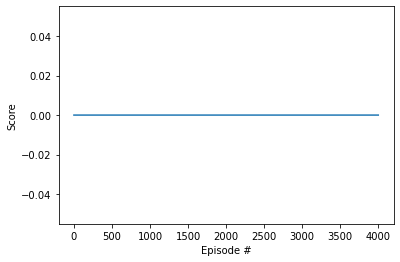

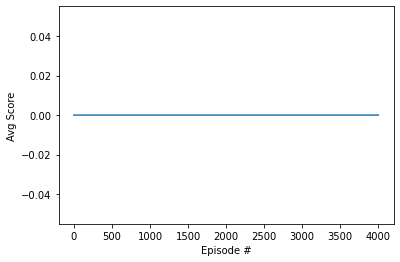


///// Beginning training set  M45.11  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999000
      Noise scale      = 1.000
      LR actor         = 0.0007653
      LR critic        = 0.0001819
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00502
      Seed             =  44939
Priming the replay buffer.........................!

76	Running avg/max: 0.000/0.000,  mem:   5167/     0 ( 0.0%), avg 497.8 eps/min   
* noise mult = 0.1
251	Running avg/max: 0.005/0.200,  mem:   5582/    11 ( 0.2%), avg 511.4 eps/min   
* noise mult = 0.0005
1000	Average score:   0.006,        mem:   7295/    35 ( 0.5%), avg 502.4 eps/min;  0.3 hr rem   
2000	Average score:   0.001,        mem:   9592/    62 ( 0.6%), avg 504.8 eps/min;  0.3 hr rem   
3000	Average score:   0.005,        mem:  11928/   114 ( 1.0%), avg 502.3 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        me

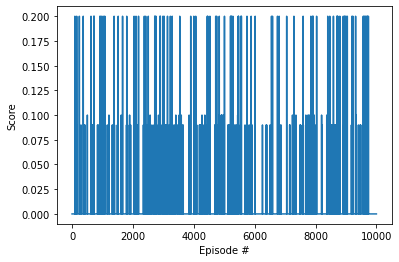

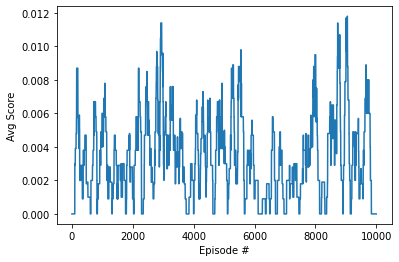


///// Beginning training set  M45.12  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999781
      Noise scale      = 0.020
      LR actor         = 0.0004310
      LR critic        = 0.0002818
      Learning every      80  time steps
      Learn iterations =  1
      Tau              = 0.00294
      Seed             =  44939
Priming the replay buffer.........................!

286	Running avg/max: 0.037/0.100,  mem:   5817/    40 ( 0.7%), avg 777.5 eps/min   
* noise mult = 0.1
934	Running avg/max: 0.002/0.100,  mem:   7721/   126 ( 1.6%), avg 768.0 eps/min   
* noise mult = 0.0005
1000	Average score:   0.003,        mem:   7887/   128 ( 1.6%), avg 771.8 eps/min;  0.2 hr rem   
2000	Average score:   0.003,        mem:  10440/   162 ( 1.6%), avg 806.4 eps/min;  0.2 hr rem   
3000	Average score:   0.003,        mem:  13017/   201 ( 1.5%), avg 817.6 eps/min;  0.1 hr rem   
4000	Average score:   0.004,        m

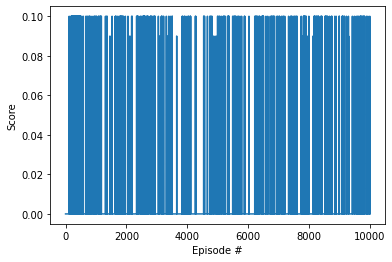

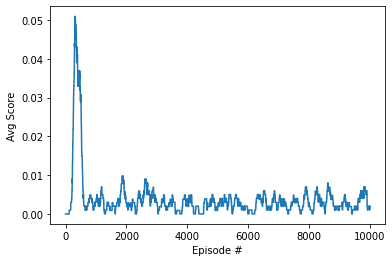


///// Beginning training set  M45.13  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999595
      Noise scale      = 0.100
      LR actor         = 0.0003914
      LR critic        = 0.0001741
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00452
      Seed             =  44939
Priming the replay buffer.........................!

176	Running avg/max: 0.005/0.200,  mem:   5445/     6 ( 0.1%), avg 263.9 eps/min   
* noise mult = 0.1
594	Running avg/max: 0.004/0.100,  mem:   6414/    16 ( 0.2%), avg 269.6 eps/min   
* noise mult = 0.0005
1000	Average score:   0.001,        mem:   7402/    23 ( 0.3%), avg 271.8 eps/min;  0.6 hr rem   
2000	Average score:   0.004,        mem:   9807/    50 ( 0.5%), avg 271.9 eps/min;  0.5 hr rem   
3000	Average score:   0.003,        mem:  12221/    83 ( 0.7%), avg 274.5 eps/min;  0.4 hr rem   
4000	Average score:   0.004,        me

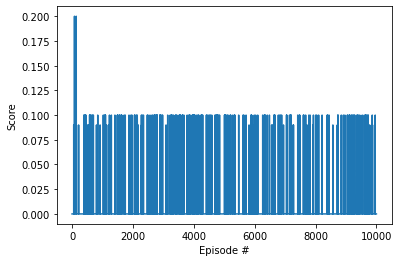

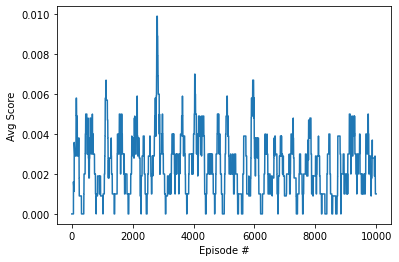


///// Beginning training set  M45.14  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999788
      Noise scale      = 0.020
      LR actor         = 0.0008618
      LR critic        = 0.0004179
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00819
      Seed             =  44939
Priming the replay buffer.........................!

368	Running avg/max: 0.000/0.000,  mem:   5823/     4 ( 0.1%), avg 534.1 eps/min   
* noise mult = 0.1
1000	Average score:   0.001,        mem:   7205/    10 ( 0.1%), avg 527.0 eps/min;  0.3 hr rem   
1225	Running avg/max: 0.002/0.100,  mem:   7687/    13 ( 0.2%), avg 523.8 eps/min   
* noise mult = 0.0005
2000	Average score:   0.002,        mem:   9404/    21 ( 0.2%), avg 524.7 eps/min;  0.3 hr rem   
3000	Average score:   0.001,        mem:  11596/    23 ( 0.2%), avg 526.9 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        

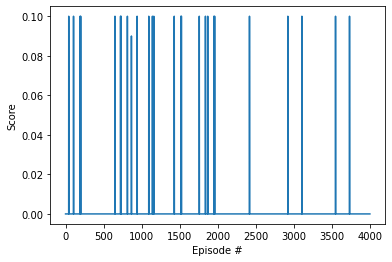

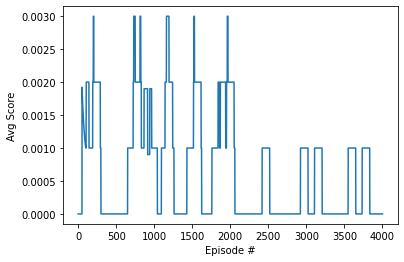


///// Beginning training set  M45.15  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999848
      Noise scale      = 0.020
      LR actor         = 0.0000368
      LR critic        = 0.0000061
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00631
      Seed             =  44939
Priming the replay buffer........................!

432	Running avg/max: 0.005/0.200,  mem:   6150/    11 ( 0.2%), avg 240.2 eps/min   
* noise mult = 0.1
1000	Average score:   0.008,        mem:   7660/    26 ( 0.3%), avg 241.9 eps/min;  0.6 hr rem   
1433	Running avg/max: 0.001/0.090,  mem:   8819/    41 ( 0.5%), avg 242.1 eps/min   
* noise mult = 0.0005
2000	Average score:   0.003,        mem:  10301/    50 ( 0.5%), avg 243.2 eps/min;  0.5 hr rem   
3000	Average score:   0.003,        mem:  12910/    73 ( 0.6%), avg 245.4 eps/min;  0.5 hr rem   
4000	Average score:   0.006,        me

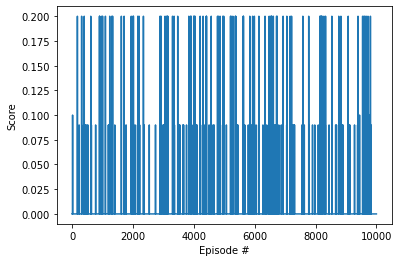

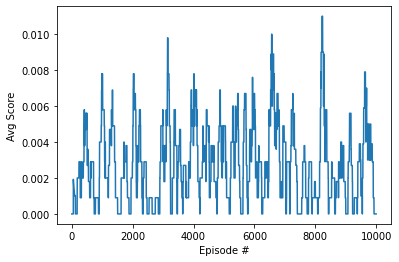


///// Beginning training set  M45.16  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999242
      Noise scale      = 0.020
      LR actor         = 0.0001598
      LR critic        = 0.0001206
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00957
      Seed             =  44939
Priming the replay buffer.........................!

95	Running avg/max: 0.000/0.000,  mem:   5233/     0 ( 0.0%), avg 105.2 eps/min   
* noise mult = 0.1
322	Running avg/max: 0.000/0.000,  mem:   5765/     0 ( 0.0%), avg 105.1 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7352/     0 ( 0.0%), avg 107.5 eps/min;  1.4 hr rem   
2000	Average score:   0.000,        mem:   9688/     0 ( 0.0%), avg 109.8 eps/min;  1.2 hr rem   
3000	Average score:   0.000,        mem:  12031/     0 ( 0.0%), avg 110.8 eps/min;  1.1 hr rem   
4000	Average score:   0.000,        mem

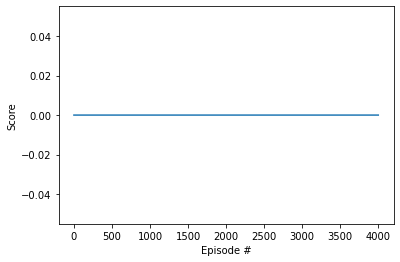

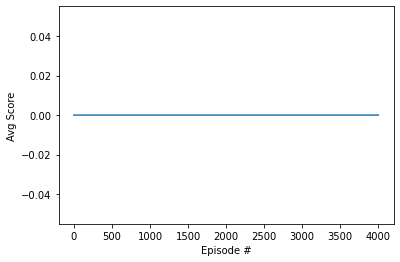


///// Beginning training set  M45.17  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999640
      Noise scale      = 1.000
      LR actor         = 0.0001987
      LR critic        = 0.0001595
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00822
      Seed             =  44939
Priming the replay buffer.........................!

207	Running avg/max: 0.003/0.100,  mem:   5506/    10 ( 0.2%), avg 107.2 eps/min   
* noise mult = 0.1
689	Running avg/max: 0.002/0.090,  mem:   6608/    21 ( 0.3%), avg 108.5 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7327/    25 ( 0.3%), avg 110.6 eps/min;  1.4 hr rem   
2000	Average score:   0.004,        mem:   9624/    64 ( 0.7%), avg 112.6 eps/min;  1.2 hr rem   
3000	Average score:   0.001,        mem:  11893/    94 ( 0.8%), avg 114.0 eps/min;  1.0 hr rem   
4000	Average score:   0.002,        me

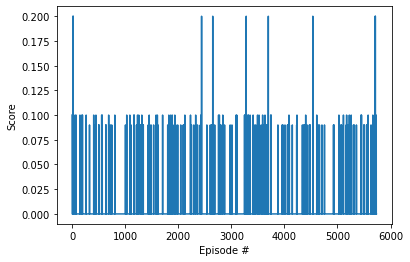

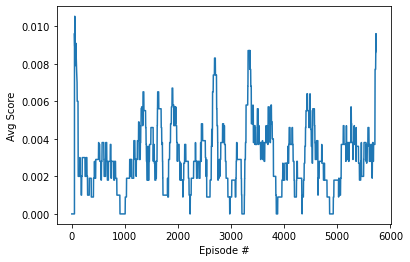


///// Beginning training set  M45.18  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999451
      Noise scale      = 0.020
      LR actor         = 0.0006500
      LR critic        = 0.0003977
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00404
      Seed             =  44939
Priming the replay buffer.........................!

133	Running avg/max: 0.000/0.000,  mem:   7097/     0 ( 0.0%), avg 262.4 eps/min   
* noise mult = 0.1
449	Running avg/max: 0.000/0.000,  mem:  11921/     0 ( 0.0%), avg 267.2 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  20234/     0 ( 0.0%), avg 274.7 eps/min;  0.5 hr rem   
2000	Average score:   0.000,        mem:  35284/     0 ( 0.0%), avg 281.9 eps/min;  0.5 hr rem   
3000	Average score:   0.000,        mem:  50419/     0 ( 0.0%), avg 284.0 eps/min;  0.4 hr rem   
4000	Average score:   0.000,        me

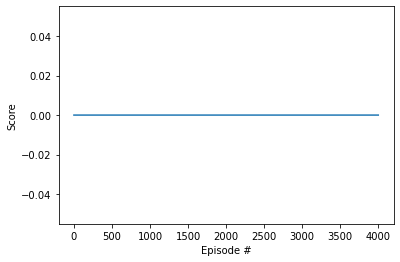

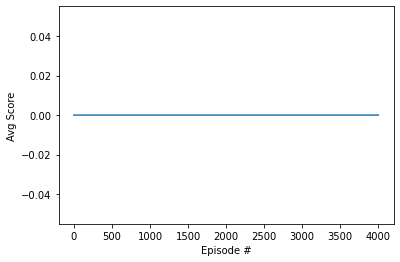


///// Beginning training set  M45.19  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999322
      Noise scale      = 0.100
      LR actor         = 0.0009053
      LR critic        = 0.0001182
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00955
      Seed             =  44939
Priming the replay buffer.........................!

91	Running avg/max: 0.003/0.100,  mem:   5265/     3 ( 0.1%), avg 411.9 eps/min   
* noise mult = 0.1
285	Running avg/max: 0.008/0.100,  mem:   5904/    28 ( 0.5%), avg 393.0 eps/min   
* noise mult = 0.0005
1000	Average score:   0.001,        mem:   7712/    32 ( 0.4%), avg 428.5 eps/min;  0.4 hr rem   
2000	Average score:   0.001,        mem:  10248/    37 ( 0.4%), avg 439.8 eps/min;  0.3 hr rem   
3000	Average score:   0.000,        mem:  12815/    45 ( 0.4%), avg 443.2 eps/min;  0.3 hr rem   
4000	Average score:   0.001,        me

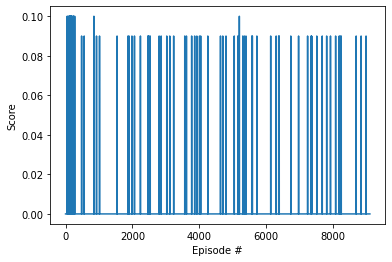

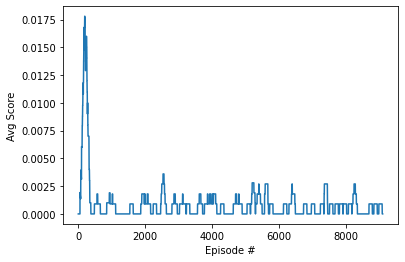


///// Beginning training set  M45.20  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999506
      Noise scale      = 1.000
      LR actor         = 0.0004828
      LR critic        = 0.0001893
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00897
      Seed             =  44939
Priming the replay buffer.........................!

141	Running avg/max: 0.002/0.100,  mem:   7326/     7 ( 0.1%), avg 109.2 eps/min   
* noise mult = 0.1
479	Running avg/max: 0.000/0.000,  mem:  12687/     7 ( 0.1%), avg 110.7 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  21014/     7 ( 0.0%), avg 112.8 eps/min;  1.3 hr rem   
2000	Average score:   0.000,        mem:  37270/     7 ( 0.0%), avg 111.9 eps/min;  1.2 hr rem   
3000	Average score:   0.000,        mem:  53419/     7 ( 0.0%), avg 54.0 eps/min;  2.2 hr rem   
4000	Average score:   0.000,        mem

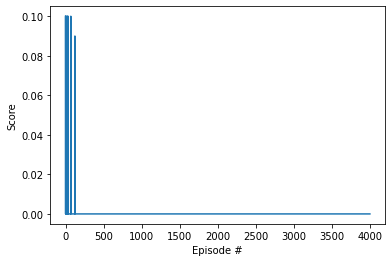

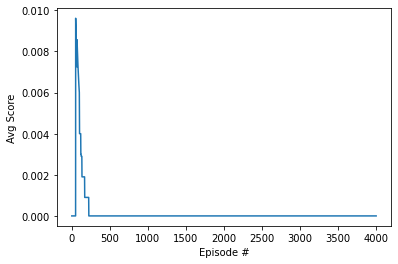


///// Beginning training set  M45.21  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999440
      Noise scale      = 0.020
      LR actor         = 0.0005237
      LR critic        = 0.0003460
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00866
      Seed             =  44939
Priming the replay buffer.........................!

115	Running avg/max: 0.002/0.100,  mem:   5317/     4 ( 0.1%), avg 241.2 eps/min   
* noise mult = 0.1
392	Running avg/max: 0.001/0.090,  mem:   6033/     6 ( 0.1%), avg 244.3 eps/min   
* noise mult = 0.0005
1000	Average score:   0.003,        mem:   7617/    15 ( 0.2%), avg 247.8 eps/min;  0.6 hr rem   
2000	Average score:   0.000,        mem:  10243/    22 ( 0.2%), avg 250.9 eps/min;  0.5 hr rem   
3000	Average score:   0.001,        mem:  12817/    31 ( 0.2%), avg 252.9 eps/min;  0.5 hr rem   
4000	Average score:   0.002,        me

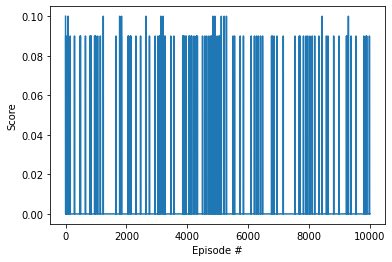

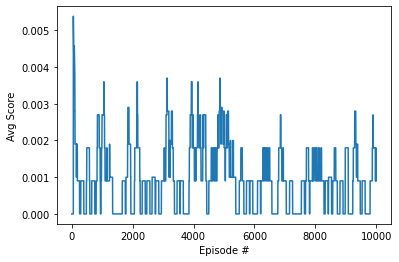


///// Beginning training set  M45.22  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999413
      Noise scale      = 0.020
      LR actor         = 0.0001988
      LR critic        = 0.0000845
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00796
      Seed             =  44939
Priming the replay buffer.........................!

115	Running avg/max: 0.000/0.000,  mem:   6961/     0 ( 0.0%), avg 248.8 eps/min   
* noise mult = 0.1
377	Running avg/max: 0.001/0.090,  mem:  11474/     3 ( 0.0%), avg 246.6 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  22182/     9 ( 0.0%), avg 247.0 eps/min;  0.6 hr rem   
2000	Average score:   0.000,        mem:  39078/    14 ( 0.0%), avg 250.3 eps/min;  0.5 hr rem   
3000	Average score:   0.001,        mem:  56225/    21 ( 0.0%), avg 251.2 eps/min;  0.5 hr rem   
4000	Average score:   0.002,        me

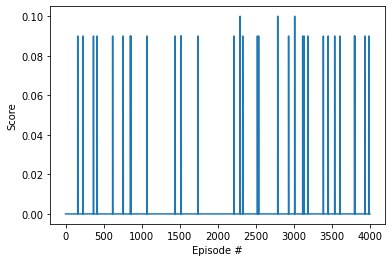

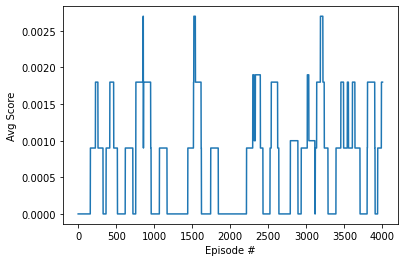


///// Beginning training set  M45.23  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999562
      Noise scale      = 0.100
      LR actor         = 0.0006236
      LR critic        = 0.0002920
      Learning every      80  time steps
      Learn iterations =  1
      Tau              = 0.00212
      Seed             =  44939
Priming the replay buffer.........................!

165	Running avg/max: 0.002/0.100,  mem:   5411/     4 ( 0.1%), avg 877.9 eps/min   
* noise mult = 0.1
550	Running avg/max: 0.000/0.000,  mem:   6308/    12 ( 0.2%), avg 885.6 eps/min   
* noise mult = 0.0005
1000	Average score:   0.001,        mem:   7438/    29 ( 0.4%), avg 888.5 eps/min;  0.2 hr rem   
2000	Average score:   0.001,        mem:   9846/    59 ( 0.6%), avg 889.6 eps/min;  0.1 hr rem   
3000	Average score:   0.005,        mem:  12277/    96 ( 0.8%), avg 885.1 eps/min;  0.1 hr rem   
4000	Average score:   0.001,        m

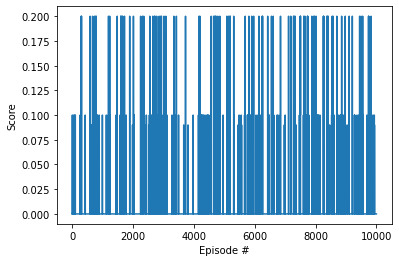

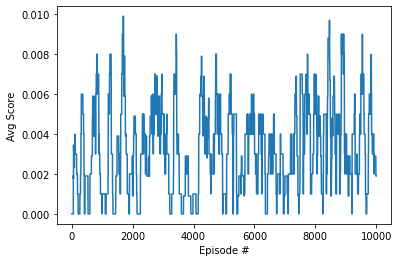


///// Beginning training set  M45.24  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999865
      Noise scale      = 0.100
      LR actor         = 0.0009910
      LR critic        = 0.0005185
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00464
      Seed             =  44939
Priming the replay buffer.........................!

566	Running avg/max: 0.001/0.090,  mem:   6307/    12 ( 0.2%), avg 507.7 eps/min   
* noise mult = 0.1
1000	Average score:   0.001,        mem:   7276/    24 ( 0.3%), avg 507.4 eps/min;  0.3 hr rem   
1856	Running avg/max: 0.001/0.090,  mem:   9274/    51 ( 0.5%), avg 504.7 eps/min   
* noise mult = 0.0005
2000	Average score:   0.006,        mem:   9627/    60 ( 0.6%), avg 503.6 eps/min;  0.3 hr rem   
3000	Average score:   0.002,        mem:  11942/    96 ( 0.8%), avg 505.1 eps/min;  0.2 hr rem   
4000	Average score:   0.002,        

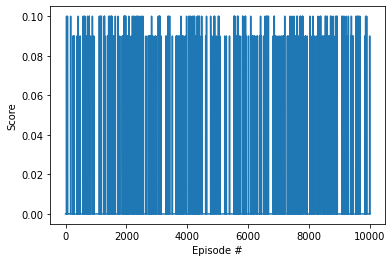

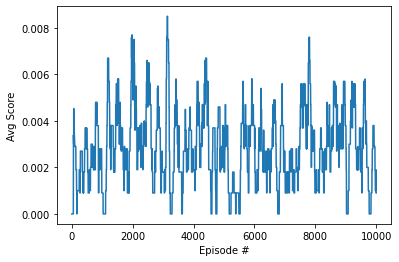


///// Beginning training set  M45.25  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999756
      Noise scale      = 0.020
      LR actor         = 0.0002832
      LR critic        = 0.0001366
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00273
      Seed             =  44939
Priming the replay buffer.........................!

299	Running avg/max: 0.000/0.000,  mem:   9717/     0 ( 0.0%), avg 104.1 eps/min   
* noise mult = 0.1
990	Running avg/max: 0.000/0.000,  mem:  20590/     0 ( 0.0%), avg 106.5 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  20748/     0 ( 0.0%), avg 106.6 eps/min;  1.4 hr rem   
2000	Average score:   0.000,        mem:  36552/     0 ( 0.0%), avg 108.8 eps/min;  1.2 hr rem   
3000	Average score:   0.000,        mem:  52205/     0 ( 0.0%), avg 63.5 eps/min;  1.8 hr rem   
4000	Average score:   0.000,        mem

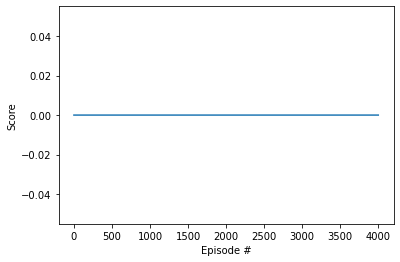

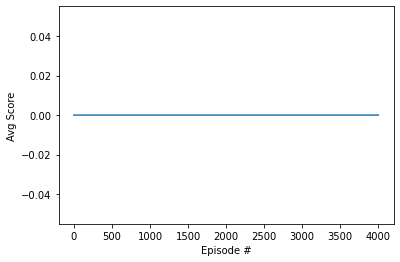


///// Beginning training set  M45.26  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999343
      Noise scale      = 0.020
      LR actor         = 0.0003209
      LR critic        = 0.0000288
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00648
      Seed             =  44939
Priming the replay buffer........................!

91	Running avg/max: 0.023/0.100,  mem:   5267/    21 ( 0.4%), avg 228.3 eps/min   
* noise mult = 0.1
339	Running avg/max: 0.001/0.090,  mem:   5905/    43 ( 0.7%), avg 249.5 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7409/    59 ( 0.8%), avg 268.7 eps/min;  0.6 hr rem   
2000	Average score:   0.003,        mem:   9729/    94 ( 1.0%), avg 273.7 eps/min;  0.5 hr rem   
3000	Average score:   0.004,        mem:  11999/   127 ( 1.1%), avg 275.8 eps/min;  0.4 hr rem   
4000	Average score:   0.000,        mem:

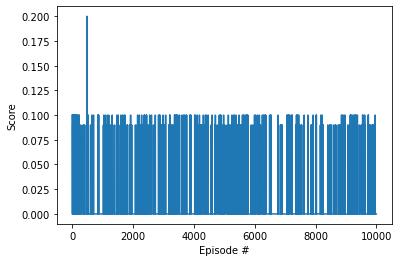

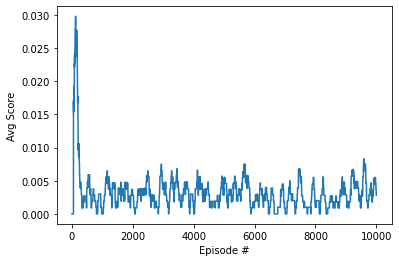


///// Beginning training set  M45.27  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999574
      Noise scale      = 0.100
      LR actor         = 0.0008977
      LR critic        = 0.0007486
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00409
      Seed             =  44939
Priming the replay buffer.........................!

160	Running avg/max: 0.000/0.000,  mem:   5411/     1 ( 0.0%), avg 252.3 eps/min   
* noise mult = 0.1
524	Running avg/max: 0.001/0.090,  mem:   6348/     5 ( 0.1%), avg 249.2 eps/min   
* noise mult = 0.0005
1000	Average score:   0.001,        mem:   7583/     7 ( 0.1%), avg 251.4 eps/min;  0.6 hr rem   
2000	Average score:   0.003,        mem:  10122/    17 ( 0.2%), avg 253.9 eps/min;  0.5 hr rem   
3000	Average score:   0.000,        mem:  12678/    23 ( 0.2%), avg 255.6 eps/min;  0.5 hr rem   
4000	Average score:   0.001,        me

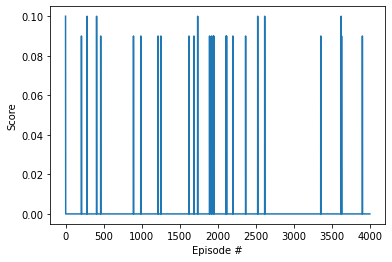

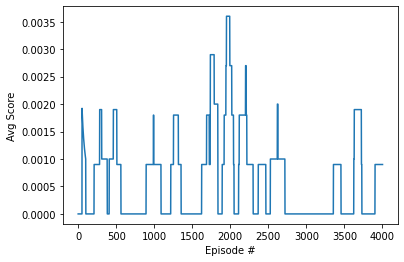


///// Beginning training set  M45.28  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999344
      Noise scale      = 1.000
      LR actor         = 0.0001494
      LR critic        = 0.0000675
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00941
      Seed             =  44939
Priming the replay buffer.........................!

107	Running avg/max: 0.006/0.100,  mem:   5284/     9 ( 0.2%), avg 102.8 eps/min   
* noise mult = 0.1
370	Running avg/max: 0.005/0.090,  mem:   5897/    23 ( 0.4%), avg 106.3 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7377/    47 ( 0.6%), avg 108.8 eps/min;  1.4 hr rem   
2000	Average score:   0.004,        mem:   9645/    78 ( 0.8%), avg 111.1 eps/min;  1.2 hr rem   
3000	Average score:   0.004,        mem:  11946/   114 ( 1.0%), avg 112.3 eps/min;  1.0 hr rem   
4000	Average score:   0.003,        me

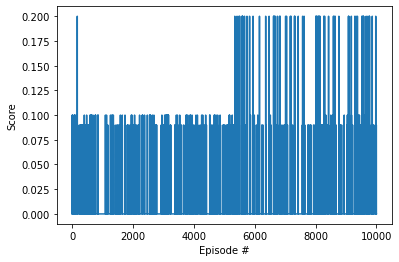

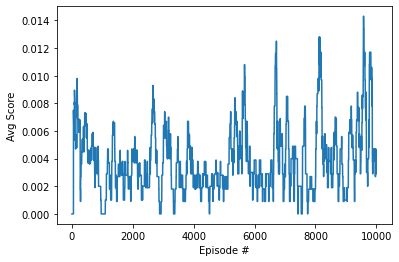


///// Beginning training set  M45.29  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999669
      Noise scale      = 0.100
      LR actor         = 0.0006099
      LR critic        = 0.0000746
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00325
      Seed             =  44939
Priming the replay buffer.........................!

224	Running avg/max: 0.000/0.000,  mem:   5532/     0 ( 0.0%), avg 454.7 eps/min   
* noise mult = 0.1
747	Running avg/max: 0.000/0.000,  mem:   6725/     0 ( 0.0%), avg 483.6 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7341/     0 ( 0.0%), avg 485.5 eps/min;  0.3 hr rem   
2000	Average score:   0.000,        mem:   9612/     0 ( 0.0%), avg 488.9 eps/min;  0.3 hr rem   
3000	Average score:   0.000,        mem:  11923/     0 ( 0.0%), avg 485.9 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        m

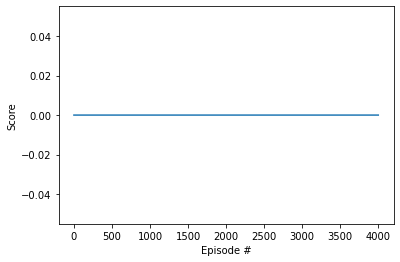

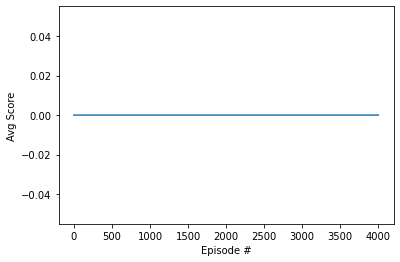



DONE!


In [4]:
# This cell will explore several combinations of hyperparams by training all of them
# Use a random search for the hyperparams

TIME_STEPS         = 600
SAVE_ANALYSIS      = False
MODEL_DISPLAY_STEP = 0 #200k is approx 10k episodes at bad_step_prob = 0.01

if EXPLORE:
    
    # fixed for the session:
    RUN_PREFIX        = "M45"
    EPISODES          = 10001
    NUM_RUNS          = 30
    BUFFER_PRIME_SIZE = 5000
    WEIGHT_DECAY      = 1.0e-5 #was 1.0e-5
    GAMMA             = 0.99
    LR_ANNEAL_FREQ    = 10000 #episodes
    LR_ANNEAL_MULT    = 1.0
    SEED              = 44939 #(0, 111, 468, 5555, 23100, 44939)
    
    # session variables:
    vars = [
            ["discrete",         0.15,      1.00],      #BAD_STEP_PROB
            ["continuous-float", 0.999000,  0.999900],  #NOISE_DECAY
            ["discrete",         0.020, 0.100, 1.000],  #NOISE_SCALE (was 0.040, 1.0)
            ["continuous-float", 0.0000200, 0.0010000], #LR_ACTOR  (was 0.000010, 0.000080)
            ["continuous-float", 0.08,      1.0],       #LR_RATIO (determines LR_CRITIC)
            ["discrete",         2, 8, 20, 80],         #LEARN_EVERY
            ["continuous-int",   1,         2],         #LEARN_ITER
            ["continuous-float", 0.00100,   0.01000],   #TAU
            ["discrete",         256]                   #BATCH
           ]
    rs = RandomSampler(vars)
    
    print("Ready to train {} over {} training sets for {} episodes each, with fixed params:"
          .format(RUN_PREFIX, NUM_RUNS, EPISODES))
    print("    Max episodes   = ", EPISODES)
    print("    Weight decay   = ", WEIGHT_DECAY)
    print("    Gamma          = ", GAMMA)
    print("    LR anneal freq = ", LR_ANNEAL_FREQ)
    print("    LR anneal mult = ", LR_ANNEAL_MULT)
    print("    Buf prime size = ", BUFFER_PRIME_SIZE)
            
    for set_id in range(NUM_RUNS):
        
        # sample the variables
        v = rs.sample()
        BAD_STEP_PROB = v[0]
        NOISE_DECAY   = v[1]
        NOISE_SCALE   = v[2]
        LR_ACTOR      = v[3]
        LR_CRITIC     = v[4] * LR_ACTOR
        LEARN_EVERY   = v[5]
        LEARN_ITER    = v[6]
        TAU           = v[7]
        BATCH         = v[8]

        # set the replay buffer size to that it fills after ~5000 bad episodes
        # (at ~14 experiences/episode), based on the bad step retention rate
        #buffer_size = int(60000 - 50000*(1.0 - BAD_STEP_PROB))
        buffer_size = 100000

        RUN_NAME = "{}.{:02d}".format(RUN_PREFIX, set_id)
        print("\n///// Beginning training set ", RUN_NAME, " with:")
        print("      Batch size       = {:d}".format(BATCH))
        print("      Buffer size      = {:d}".format(buffer_size))
        print("      Bad step prob    = {:.4f}".format(BAD_STEP_PROB))
        print("      Noise decay      = {:.6f}".format(NOISE_DECAY))
        print("      Noise scale      = {:.3f}".format(NOISE_SCALE))
        print("      LR actor         = {:.7f}".format(LR_ACTOR))
        print("      LR critic        = {:.7f}".format(LR_CRITIC))
        print("      Learning every     ", LEARN_EVERY, " time steps")
        print("      Learn iterations = ", LEARN_ITER)
        print("      Tau              = {:.5f}".format(TAU))
        print("      Seed             = ", SEED)

        ##### instantiate the agents and perform the training

        maddpg = Maddpg(state_size, action_size, 2, bad_step_prob=BAD_STEP_PROB,
                        random_seed=SEED, batch_size=BATCH, buffer_size=buffer_size,
                        noise_decay=NOISE_DECAY, buffer_prime_size=BUFFER_PRIME_SIZE,
                        learn_every=LEARN_EVERY, 
                        learn_iter=LEARN_ITER, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC,
                        lr_anneal_freq=LR_ANNEAL_FREQ, lr_anneal_mult=LR_ANNEAL_MULT,
                        weight_decay=WEIGHT_DECAY, gamma=GAMMA, noise_scale=NOISE_SCALE,
                        tau=TAU, model_display_step=MODEL_DISPLAY_STEP)
        
        if config_name != None:
            print("///// Beginning training from checkpoint for {}, episode {}" \
                  .format(tag, initial_episode))
            maddpg.restore_checkpoint(checkpoint_path, tag, initial_episode)

        scores, avgs = train(maddpg, env, run_name=RUN_NAME, starting_episode=initial_episode,
                             max_episodes=EPISODES, winning_score=0.5, max_time_steps=TIME_STEPS,
                             checkpoint_interval=1000)

        ##### plot the training reward history

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(avgs)), avgs)
        plt.ylabel('Avg Score')
        plt.xlabel('Episode #')
        plt.show()

        ##### store the action/noise data, if being used

        if SAVE_ANALYSIS:
            maddpg.save_anal_data(RUN_PREFIX)

                            
    print("\n\nDONE!")

# HEY JOHN - TODO!

- update main.py to match the above code {ALL CELLS}
- Test running from cmd line (may need a script?)
- Clean up the bottom part of this notebook

### Run two trained agents against each other (inference mode)

Note:  before running this cell, the Unity environment object will need to be defined (at top of notebook) with `no_graphics=False` so that the graphical game display will appear.

In [5]:
if not EXPLORE:
    
    # load the pre-trained model
    model = Maddpg(state_size, action_size, 2)
    model.restore_checkpoint(checkpoint_path, tag, initial_episode)

    for i in range(10):                                        # play game for several episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        num_steps = 0
        while True:
            actions = model.act(states, add_noise=False)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            num_steps += 1
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Episode {}: {:5.3f}, took {} steps'.format(i, np.max(scores), num_steps))


When finished, you can close the environment.

In [6]:
env.close()